In [1]:
library(DiffBind)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [2]:
library(repr)

NFKB and ND Data

In [3]:
all.samples <- read.csv("../../SampleSheet.csv")
nfkb.nd.samples <- all.samples[grepl("ND", all.samples$sample_name) | grepl("NFKB", all.samples$sample_name), 1:3]
colnames(nfkb.nd.samples) <-  c("SampleID", "Sex", "Batch")
nfkb.nd.samples$Condition <- lapply(nfkb.nd.samples$SampleID, function (x) {
    s <- unlist(strsplit(x, "_", TRUE))
    s[length(s) - 1]
})

In [4]:
nfkb.nd.samples$bamReads <- paste0("../../bam/", nfkb.nd.samples$SampleID, ".trimmed.bowtie2.filtered.bam")
nfkb.nd.samples$Peaks <- paste0("../../macs2_results/", nfkb.nd.samples$SampleID, "/", 
                                nfkb.nd.samples$SampleID, "_peaks.narrowPeak")
nfkb.nd.samples$PeakCaller <- "narrow"
head(nfkb.nd.samples)

,SampleID,Sex,Batch,Condition,bamReads,Peaks,PeakCaller
,<chr>,<chr>,<int>,<list>,<chr>,<chr>,<chr>
1,ATAC024_CB_FR005.1_NFKB1_sB,female,20200205,NFKB1,../../bam/ATAC024_CB_FR005.1_NFKB1_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC024_CB_FR005.1_NFKB1_sB/ATAC024_CB_FR005.1_NFKB1_sB_peaks.narrowPeak,narrow
17,ATAC074_CB_FR023.1_NFKB1_sB,female,20200217,NFKB1,../../bam/ATAC074_CB_FR023.1_NFKB1_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC074_CB_FR023.1_NFKB1_sB/ATAC074_CB_FR023.1_NFKB1_sB_peaks.narrowPeak,narrow
25,ATAC100_CB_FR032.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC100_CB_FR032.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC100_CB_FR032.1_NFKB2_sB/ATAC100_CB_FR032.1_NFKB2_sB_peaks.narrowPeak,narrow
26,ATAC102_CB_FR033.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC102_CB_FR033.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC102_CB_FR033.1_NFKB2_sB/ATAC102_CB_FR033.1_NFKB2_sB_peaks.narrowPeak,narrow
27,ATAC105_CB_FR034.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC105_CB_FR034.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC105_CB_FR034.1_NFKB2_sB/ATAC105_CB_FR034.1_NFKB2_sB_peaks.narrowPeak,narrow
28,ATAC108_CB_FR035.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC108_CB_FR035.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC108_CB_FR035.1_NFKB2_sB/ATAC108_CB_FR035.1_NFKB2_sB_peaks.narrowPeak,narrow


filter low quality samples

In [5]:
valid.samples <- lapply(nfkb.nd.samples$Peaks, function (x) {
    if (file.exists(x)) {
        if (nrow(read.csv(x)) >= 10000) {
            return(TRUE)
        }
    }
    FALSE
})
cat(paste(c("Removed samples:", nfkb.nd.samples$SampleID[!unlist(valid.samples)], "\n"), " "))
nfkb.nd.samples <- nfkb.nd.samples[unlist(valid.samples), ]
cat(paste(c("Unique batchs:", unique(nfkb.nd.samples$Batch)), " "))

Removed samples:   ATAC024_CB_FR005.1_NFKB1_sB   ATAC161_CB_FR053.1_NFKB1_sB   
  Unique batchs:   20200217   20200602   20200828  

In [6]:
head(nfkb.nd.samples)

,SampleID,Sex,Batch,Condition,bamReads,Peaks,PeakCaller
,<chr>,<chr>,<int>,<list>,<chr>,<chr>,<chr>
17,ATAC074_CB_FR023.1_NFKB1_sB,female,20200217,NFKB1,../../bam/ATAC074_CB_FR023.1_NFKB1_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC074_CB_FR023.1_NFKB1_sB/ATAC074_CB_FR023.1_NFKB1_sB_peaks.narrowPeak,narrow
25,ATAC100_CB_FR032.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC100_CB_FR032.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC100_CB_FR032.1_NFKB2_sB/ATAC100_CB_FR032.1_NFKB2_sB_peaks.narrowPeak,narrow
26,ATAC102_CB_FR033.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC102_CB_FR033.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC102_CB_FR033.1_NFKB2_sB/ATAC102_CB_FR033.1_NFKB2_sB_peaks.narrowPeak,narrow
27,ATAC105_CB_FR034.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC105_CB_FR034.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC105_CB_FR034.1_NFKB2_sB/ATAC105_CB_FR034.1_NFKB2_sB_peaks.narrowPeak,narrow
28,ATAC108_CB_FR035.1_NFKB2_sB,female,20200217,NFKB2,../../bam/ATAC108_CB_FR035.1_NFKB2_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC108_CB_FR035.1_NFKB2_sB/ATAC108_CB_FR035.1_NFKB2_sB_peaks.narrowPeak,narrow
29,ATAC111_CB_FR036.1_NFKB1_sB,female,20200217,NFKB1,../../bam/ATAC111_CB_FR036.1_NFKB1_sB.trimmed.bowtie2.filtered.bam,../../macs2_results/ATAC111_CB_FR036.1_NFKB1_sB/ATAC111_CB_FR036.1_NFKB1_sB_peaks.narrowPeak,narrow


DiffBind Contrast

In [7]:
db.obj <- dba(sampleSheet = nfkb.nd.samples, bRemoveM = TRUE)
db.obj

ATAC074_CB_FR023.1_NFKB1_sB   NFKB1  NA narrow

ATAC100_CB_FR032.1_NFKB2_sB   NFKB2  NA narrow

ATAC102_CB_FR033.1_NFKB2_sB   NFKB2  NA narrow

ATAC105_CB_FR034.1_NFKB2_sB   NFKB2  NA narrow

ATAC108_CB_FR035.1_NFKB2_sB   NFKB2  NA narrow

ATAC111_CB_FR036.1_NFKB1_sB   NFKB1  NA narrow

ATAC123_CB_FR040.1_ND_sB   ND  NA narrow

ATAC137_CB_FR045.1_ND_sB   ND  NA narrow

ATAC140_CB_FR046.1_ND_sB   ND  NA narrow

ATAC143_CB_FR047.1_ND_sB   ND  NA narrow

ATAC146_CB_FR048.1_ND_sB   ND  NA narrow

ATAC149_CB_FR049.1_ND_sB   ND  NA narrow

ATAC152_CB_FR050.1_ND_sB   ND  NA narrow

ATAC155_CB_FR051.1_ND_sB   ND  NA narrow

ATAC158_CB_FR052.1_ND_sB   ND  NA narrow

ATAC176_CB_FR058.1_ND_sB   ND  NA narrow

ATAC185_CB_FR061.1_ND_sB   ND  NA narrow

ATAC188_CB_FR062.1_ND_sB   ND  NA narrow

ATAC191_CB_FR063.1_ND_sB   ND  NA narrow

ATAC194_CB_FR064.1_ND_sB   ND  NA narrow

ATAC206_CB_FR069.1_ND_sB   ND  NA narrow

ATAC224_CB_FR075.1_ND_sB   ND  NA narrow

ATAC239_CB_FR079.1_ND_sB   ND  NA narrow

29 Samples, 71461 sites in matrix (94289 total):
                            ID Condition Intervals
1  ATAC074_CB_FR023.1_NFKB1_sB     NFKB1     39364
2  ATAC100_CB_FR032.1_NFKB2_sB     NFKB2     37010
3  ATAC102_CB_FR033.1_NFKB2_sB     NFKB2     39284
4  ATAC105_CB_FR034.1_NFKB2_sB     NFKB2     31124
5  ATAC108_CB_FR035.1_NFKB2_sB     NFKB2     24386
6  ATAC111_CB_FR036.1_NFKB1_sB     NFKB1     43964
7     ATAC123_CB_FR040.1_ND_sB        ND     33879
8     ATAC137_CB_FR045.1_ND_sB        ND     51609
9     ATAC140_CB_FR046.1_ND_sB        ND     53394
10    ATAC143_CB_FR047.1_ND_sB        ND     51851
11    ATAC146_CB_FR048.1_ND_sB        ND     37563
12    ATAC149_CB_FR049.1_ND_sB        ND     46183
13    ATAC152_CB_FR050.1_ND_sB        ND     55939
14    ATAC155_CB_FR051.1_ND_sB        ND     60298
15    ATAC158_CB_FR052.1_ND_sB        ND     51580
16    ATAC176_CB_FR058.1_ND_sB        ND     50060
17    ATAC185_CB_FR061.1_ND_sB        ND     52779
18    ATAC188_CB_FR062.1_ND_sB   

In [9]:
db.obj <- dba.blacklist(db.obj, blacklist = DBA_BLACKLIST_HG38, greylist = FALSE)

Genome detected: Hsapiens.UCSC.hg38

Applying blacklist...

Removed: 1531 of 1354698 intervals.

Removed: 187 merged (of 94289) and 118 (of 71461) consensus.



In [13]:
# db.obj$config$singleEnd <- FALSE
db.obj <- dba.count(db.obj)

Computing summits...

Re-centering peaks...



In [12]:
db.obj <- dba.contrast(db.obj, reorderMeta = list(Condition="ND"), minMembers=2, design="~ Condition")

Computing results names...



Norm by full lib

In [17]:
db.obj <- dba.normalize(db.obj, normalize = DBA_NORM_NATIVE, background = TRUE)

Generating background bins...



In [18]:
dba.show(db.obj,)

,ID,Condition,Caller,Intervals,Reads,FRiP
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,ATAC074_CB_FR023.1_NFKB1_sB,NFKB1,counts,69528,17037728,0.14
2,ATAC100_CB_FR032.1_NFKB2_sB,NFKB2,counts,69528,14999849,0.16
3,ATAC102_CB_FR033.1_NFKB2_sB,NFKB2,counts,69528,15709236,0.16
4,ATAC105_CB_FR034.1_NFKB2_sB,NFKB2,counts,69528,17834463,0.11
5,ATAC108_CB_FR035.1_NFKB2_sB,NFKB2,counts,69528,14668534,0.10
6,ATAC111_CB_FR036.1_NFKB1_sB,NFKB1,counts,69528,19705624,0.15
7,ATAC123_CB_FR040.1_ND_sB,ND,counts,69528,14896989,0.13
8,ATAC137_CB_FR045.1_ND_sB,ND,counts,69528,19206090,0.15
9,ATAC140_CB_FR046.1_ND_sB,ND,counts,69528,20835035,0.14


In [55]:
db.obj <- dba.analyze(db.obj)

Analyzing...

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



Warning message:
“Unable to re-order returned correlation matrix as labels are non-unique”


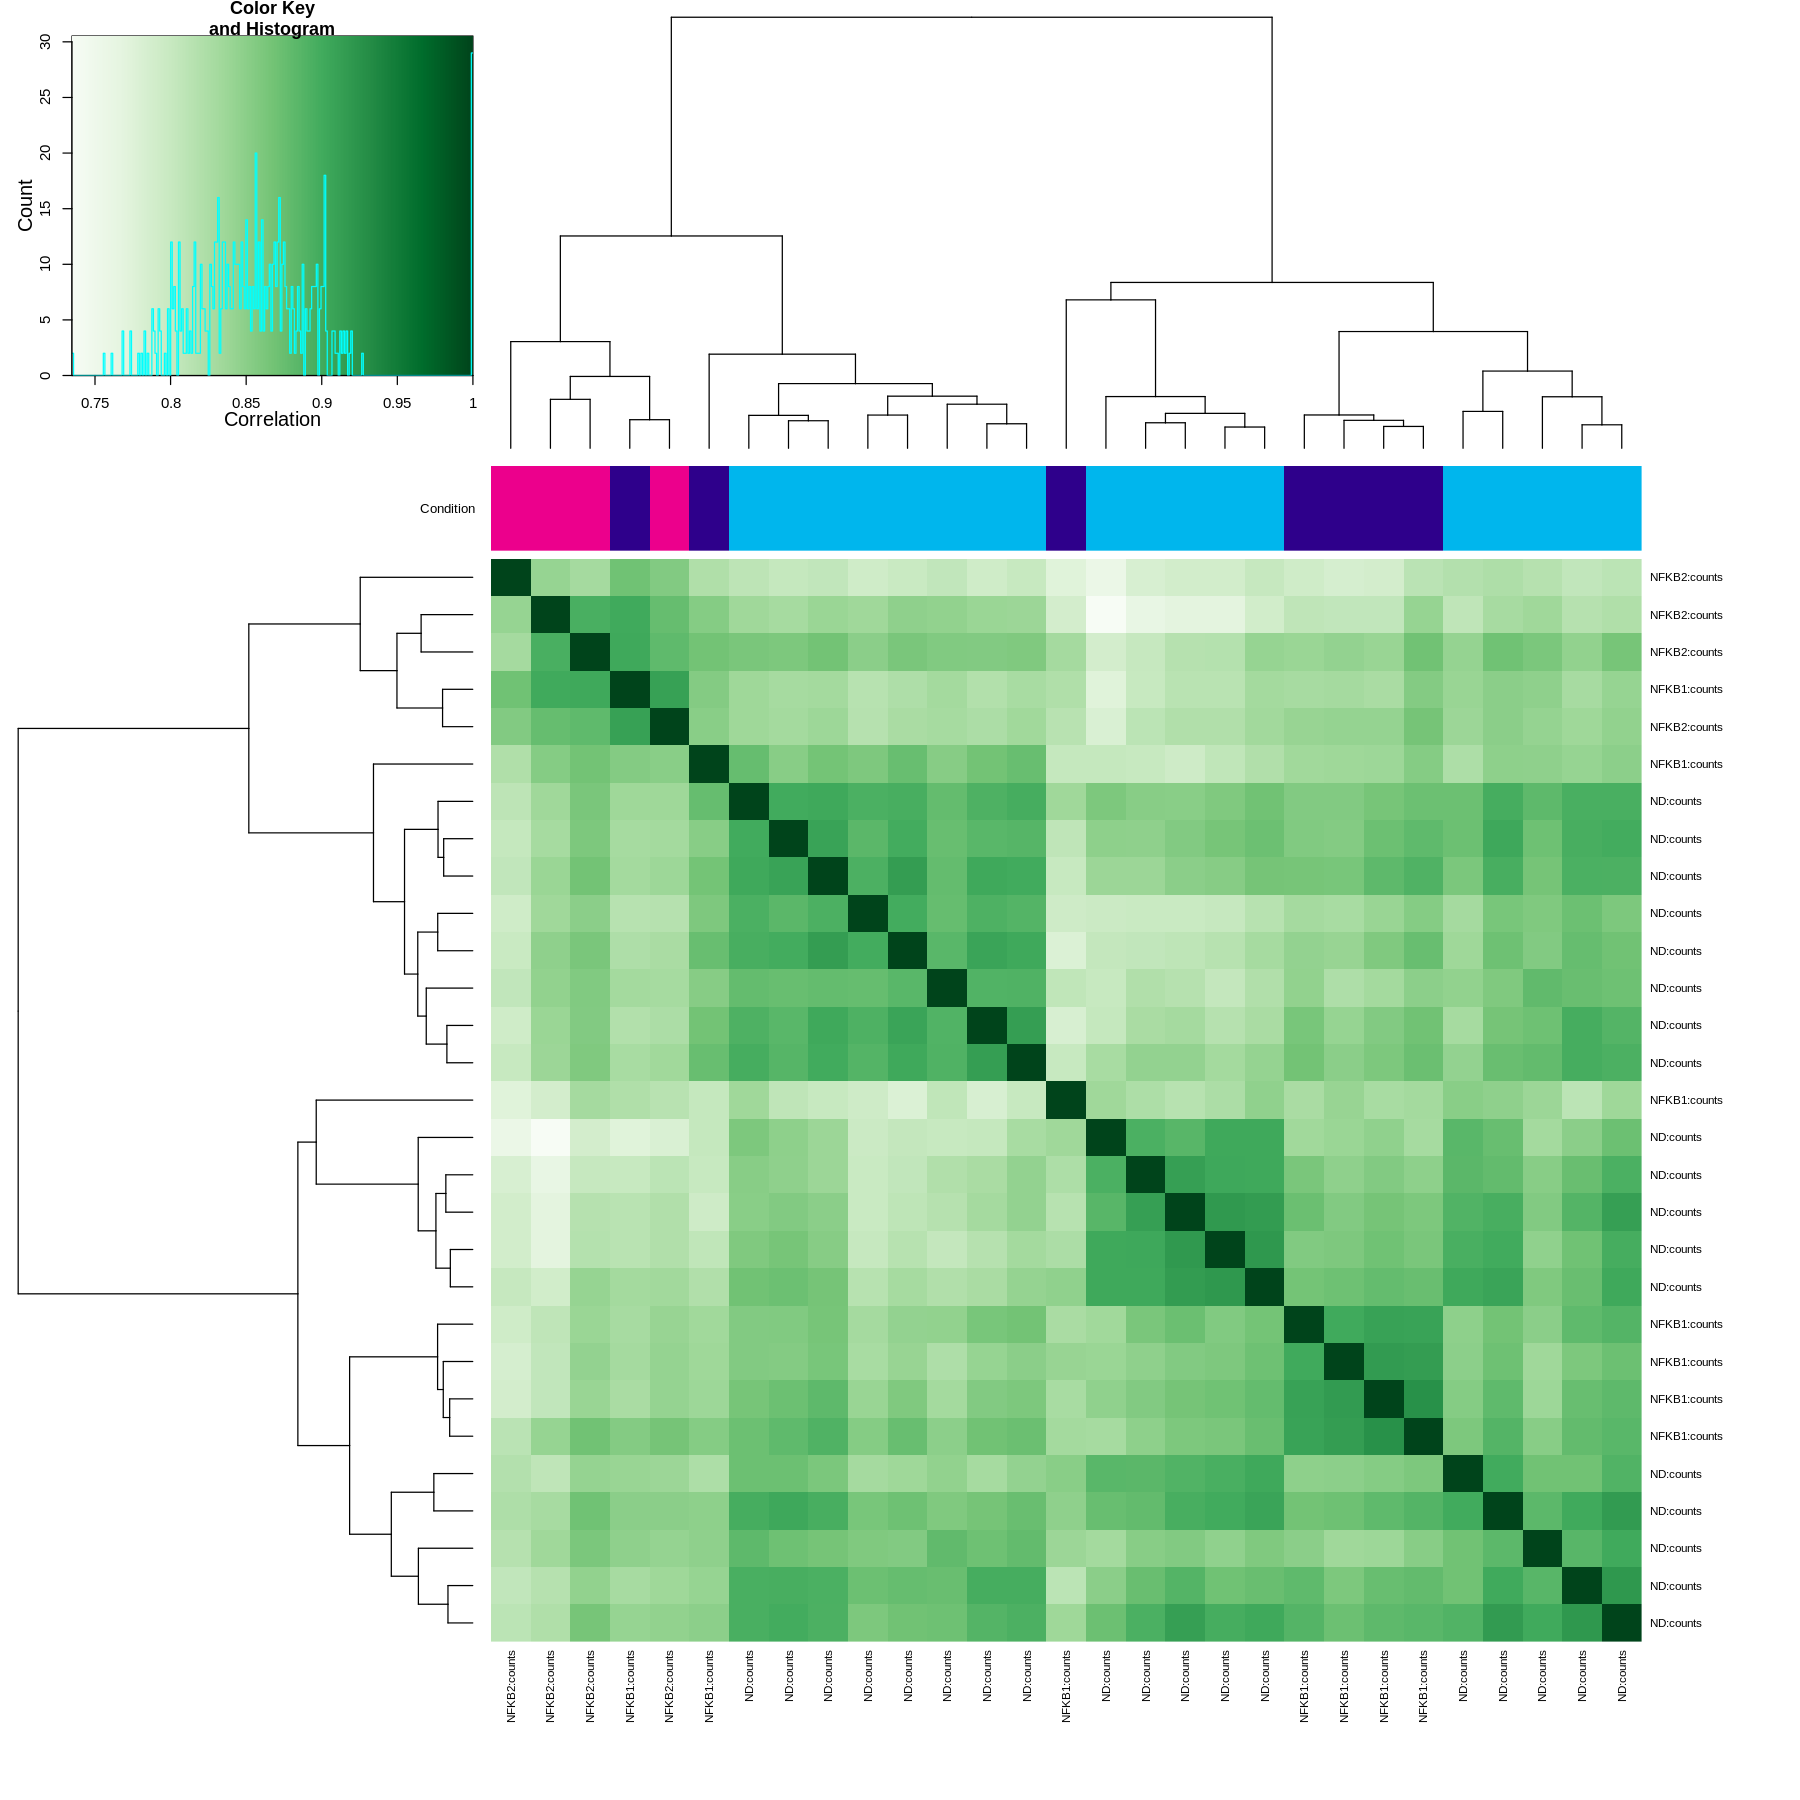

In [22]:
options(repr.plot.width=15, repr.plot.height=15)
plot(db.obj, attributes=c(DBA_CONDITION, DBA_CALLER))

Norm by RLE

In [82]:
db.obj <- dba.normalize(db.obj, normalize = DBA_NORM_NATIVE)

In [83]:
db.obj <- dba.analyze(db.obj)

Analyzing...

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



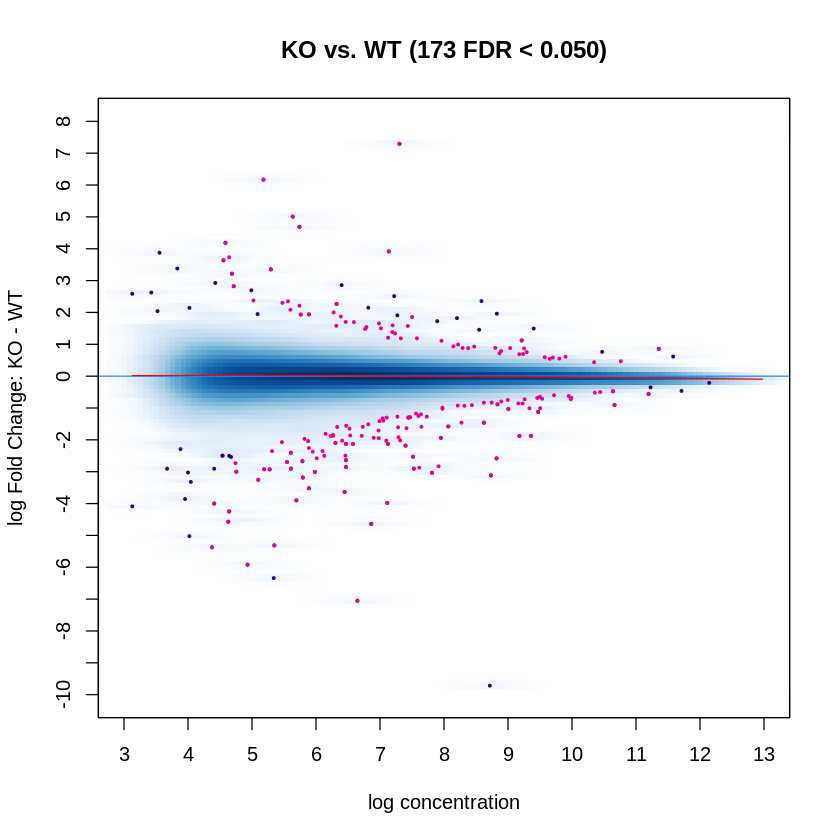

In [77]:
dba.plotMA(db.obj, method=DBA_DESEQ2, bNormalized = FALSE)

In [84]:
dba.show(db.obj, bContrasts=TRUE)

,Factor,Group,Samples,Group2,Samples2,DB.DESeq2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Condition,KO,2,WT,2,367


In [85]:
dba.report(db.obj, th=1, file = "ATAC_DiffBind_Call.norm_native")

GRanges object with 79620 ranges and 6 metadata columns:
        seqnames              ranges strand |      Conc   Conc_KO   Conc_WT
           <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
  23854    chr14   47854447-47854847      * |   8.71905   6.46759   9.55901
  10663    chr11   30705089-30705489      * |   8.80781   7.01446   9.58307
   2895     chr1 136576012-136576412      * |   9.35156   8.14036  10.00056
   2710     chr1 134231354-134231754      * |   7.80391   5.62352   8.63529
  62020     chr6   70023805-70024205      * |   7.89835   5.88830   8.70714
    ...      ...                 ...    ... .       ...       ...       ...
   1316     chr1   64782690-64783090      * |   8.65963   8.65947   8.65979
  38618    chr19     7471401-7471801      * |   5.88383   5.88351   5.88415
   8963    chr10 110556301-110556701      * |   6.73730   6.73839   6.73622
  45897     chr2 164198937-164199337      * |   8.34082   8.34038   8.34125
  32086    chr16   96413742-964

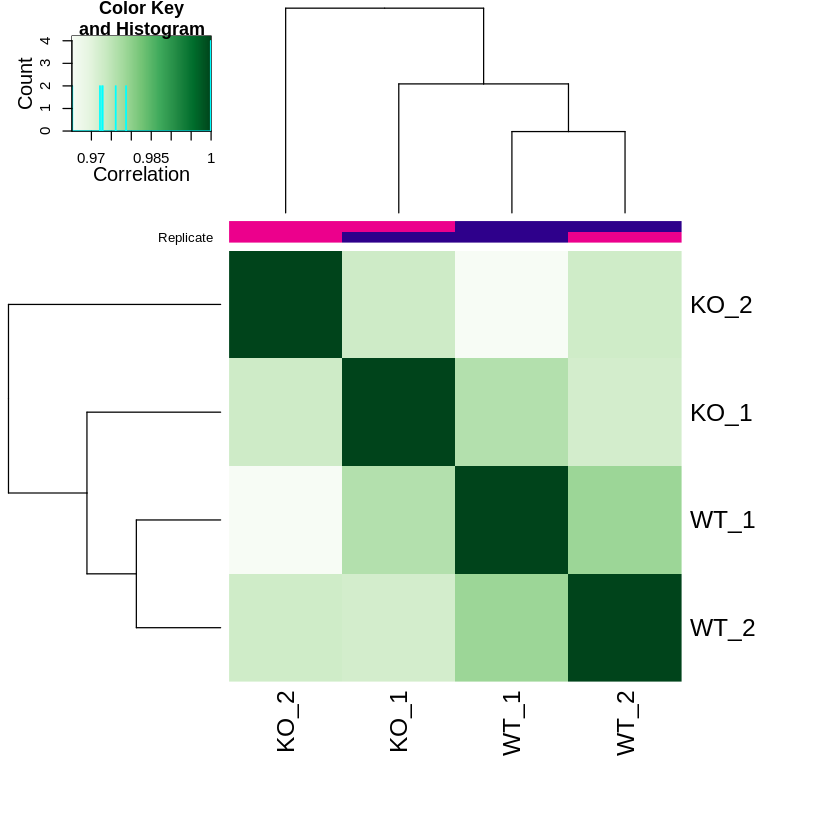

In [48]:
plot(db.obj)

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”


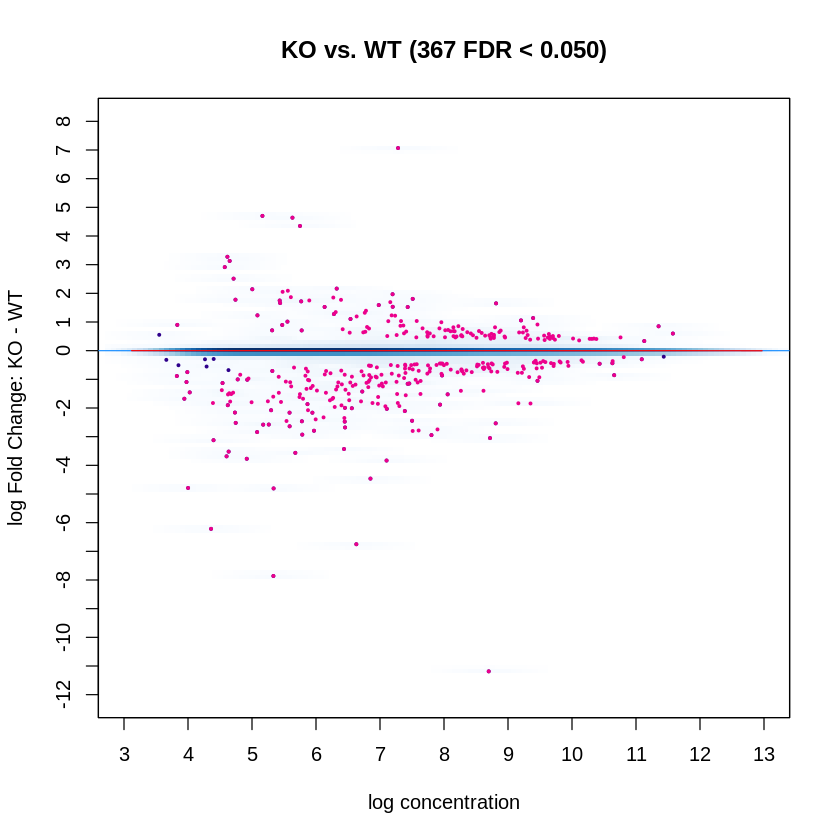

In [63]:
dba.plotMA(db.obj, method=DBA_DESEQ2)

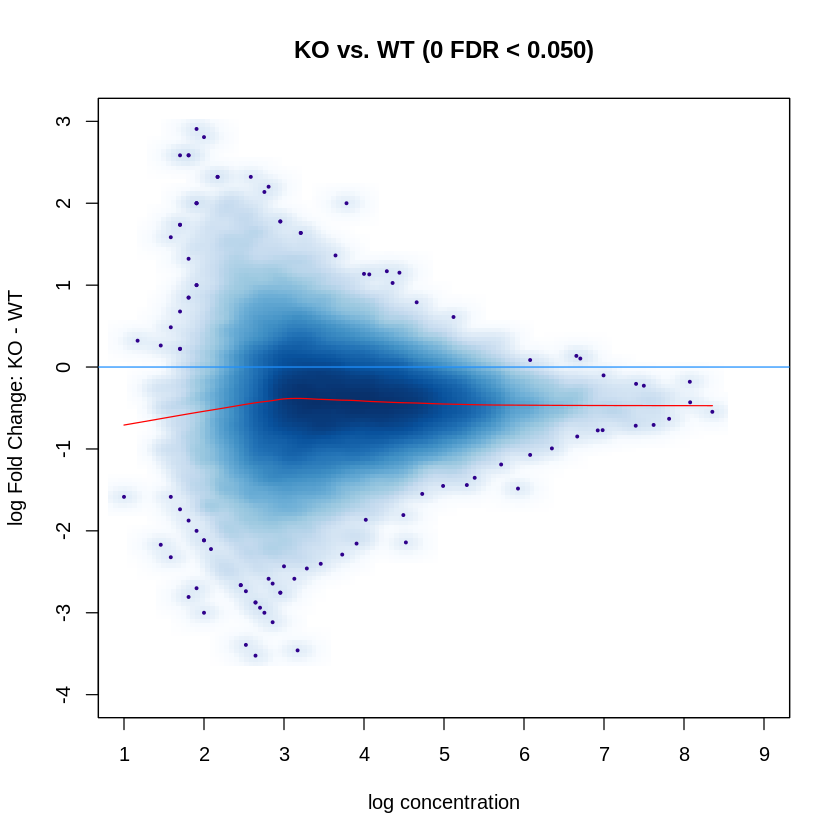

In [70]:
dba.plotMA(db.obj, method=DBA_DESEQ2, bNormalized = FALSE)